In [33]:
# import library 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('dark_background')

# Elementary Data Analysis of HSI Data

In this session, we will focus on the EDA of HSI data. There are 7 columns in the dataset 
1. Date: Datetime of HSI 
2. Open: The open price of HSI 
3. HIgh: The highest price of HSI in that day 
4. Low: The lowest price of HSI in that day 
5. Close: The closing price of HSI 
6. Up Votes & Down Votes: The sentiment or opinion expressed by social media users regarding the expected direction of the stock. Note that $\text{Up Votes} + \text{Down Votes} =  1$


In [34]:
# read HSI file 
df = pd.read_excel("HSI.xlsx")
df.head()

,Date,Open,High,Low,Close,Up votes,Down votes
0,2022-02-24,23268.03,23376.37,22786.39,22901.56,0.69,0.31
1,2022-02-25,22908.10,23046.86,22718.15,22767.18,0.36,0.64
2,2022-02-28,22818.17,22818.17,22406.12,22713.02,0.61,0.49
3,2022-03-01,22739.84,22937.56,22591.73,22761.71,0.49,0.51
4,2022-03-02,22568.36,22712.44,22299.14,22343.92,0.48,0.52


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        416 non-null    datetime64[ns]
 1   Open        416 non-null    float64       
 2   High        416 non-null    float64       
 3   Low         416 non-null    float64       
 4   Close       416 non-null    float64       
 5   Up votes    340 non-null    float64       
 6   Down votes  340 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 22.9 KB


In [36]:
nullCount = df.isnull().sum()
nullCount 

Date           0
Open           0
High           0
Low            0
Close          0
Up votes      76
Down votes    76
dtype: int64

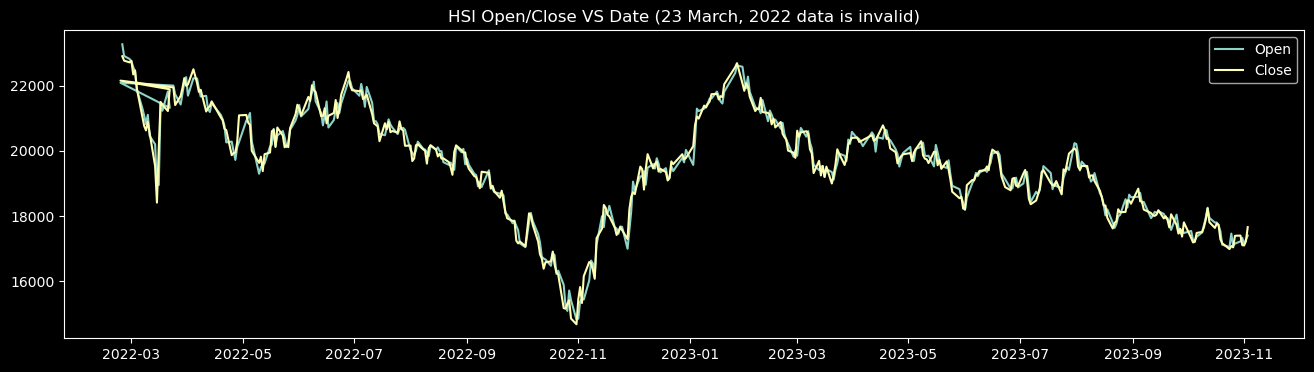

In [37]:
# there is an anomaly data point in 23-3-2022, this is because incorrect date logging (23-3-2022 <-> 23-2-2022)
plt.figure(figsize=(16,4))
plt.plot(df['Date'], df["Open"], label=f"Open")
plt.plot(df['Date'], df["Close"], label=f"Close")
plt.title("HSI Open/Close VS Date (23 March, 2022 data is invalid)")
plt.legend()

In [38]:
# correct the 23-3-2022 date 
df.at[19, 'Date'] = pd.to_datetime('2022-03-26')

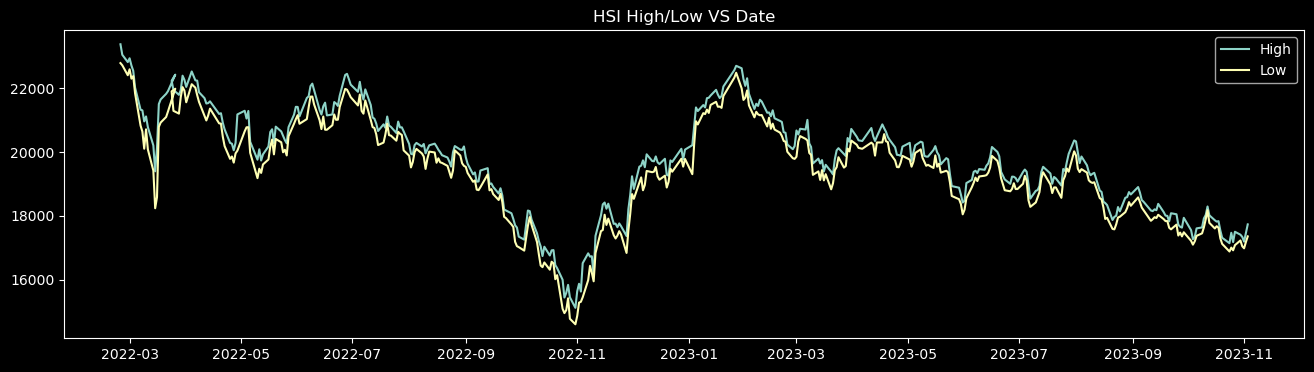

In [39]:
plt.figure(figsize=(16,4))
plt.plot(df['Date'], df["High"], label=f"High")
plt.plot(df['Date'], df["Low"], label=f"Low")
plt.title("HSI High/Low VS Date")
plt.legend()

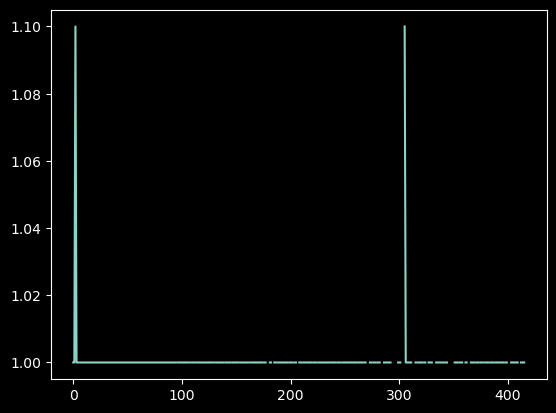

In [40]:
# check up + down votes 
# There are two anomalies inside the df 
plt.plot(df["Up votes"] + df["Down votes"])

In [41]:
vote_sum = df["Up votes"] + df["Down votes"]
vote_sum[vote_sum > 1]

2      1.1
305    1.1
dtype: float64

In [42]:
# correct the vote and replace NaN by mean 
mean_up = df["Up votes"].mean()

#replace Nan by mean in Up Votes column
df['Up votes'].fillna(mean_up, inplace=True)

# correct the down votes by 1 - up_votes
df["Down votes"] = 1 - df["Up votes"]

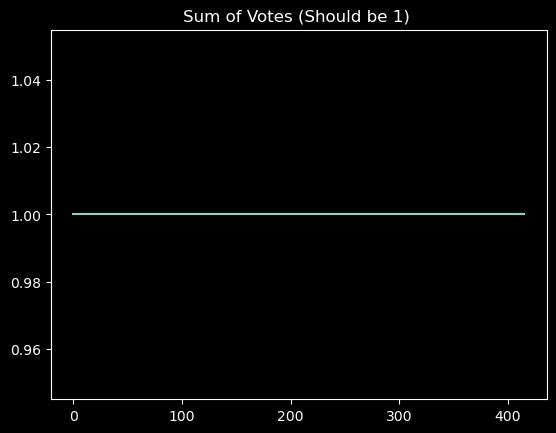

In [43]:
# check vote_sum 
plt.title('Sum of Votes (Should be 1) ')
plt.plot(df["Up votes"] + df["Down votes"] ) 

In [44]:
# Features Engineering 
df["Mid"] = (df["High"] + df["Low"])/2

In [45]:
# Investigate the correlation matrix
corr_matrix = df[['Open', "Close","High","Low","Mid","Up votes"]].corr()
corr_matrix

,Open,Close,High,Low,Mid,Up votes
Open,1.000000,0.988119,0.994404,0.995428,0.996326,0.161327
Close,0.988119,1.000000,0.995806,0.994385,0.996507,0.155918
High,0.994404,0.995806,1.000000,0.994341,0.998588,0.151951
Low,0.995428,0.994385,0.994341,1.000000,0.998581,0.157527
Mid,0.996326,0.996507,0.998588,0.998581,1.000000,0.154955
Up votes,0.161327,0.155918,0.151951,0.157527,0.154955,1.000000


Text(0.5, 0, 'Stock Price')

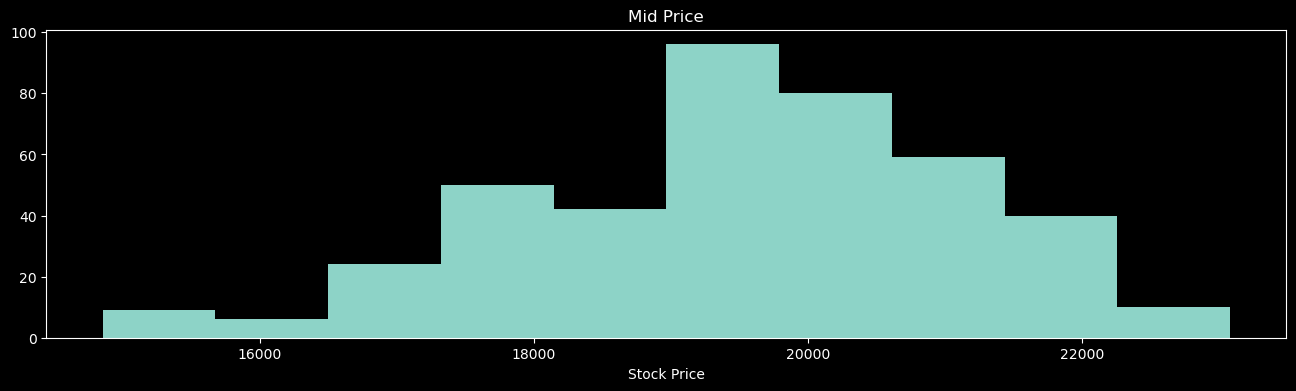

In [46]:
plt.figure(figsize=(16,4))
plt.title(f"Mid Price")
plt.hist(df['Mid'])
plt.xlabel(f"Stock Price")

# Moving Average Convergence Divergence (MACD)

In [47]:
# define the time series 
window_size_fast, window_size_short = 26, 12 
signal_line, macd_line = df['Open'].rolling(window=window_size_fast).mean(), df['Open'].rolling(window=window_size_short).mean()
diff_line =  macd_line - signal_line

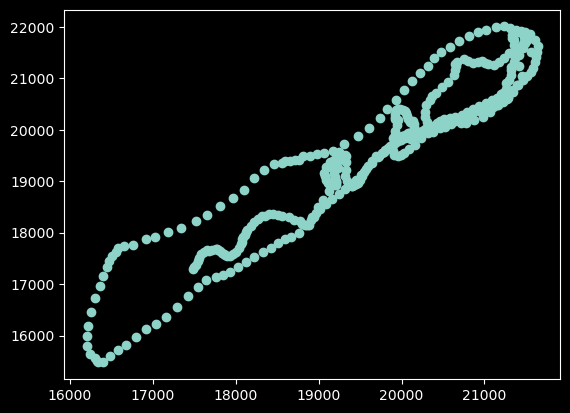

In [48]:
# Sctter plot 
plt.scatter(signal_line, macd_line)

In [49]:
from sklearn.linear_model import LinearRegression

# Create a linear regression object
lm = LinearRegression()


x = (signal_line[~np.isnan(signal_line) ]).values.reshape(-1,1) / signal_line.max()
y = (macd_line[~np.isnan(macd_line) ]).values[:len(x)] / macd_line.max()

# Train the model using the training sets
lm.fit(x, y)

# Print out the coefficients
print('Intercept:', lm.intercept_)
print('Slope:', lm.coef_[0])

Intercept: 0.012639582656056358
Slope: 0.9727163252044909


Text(0.5, 0, 'date')

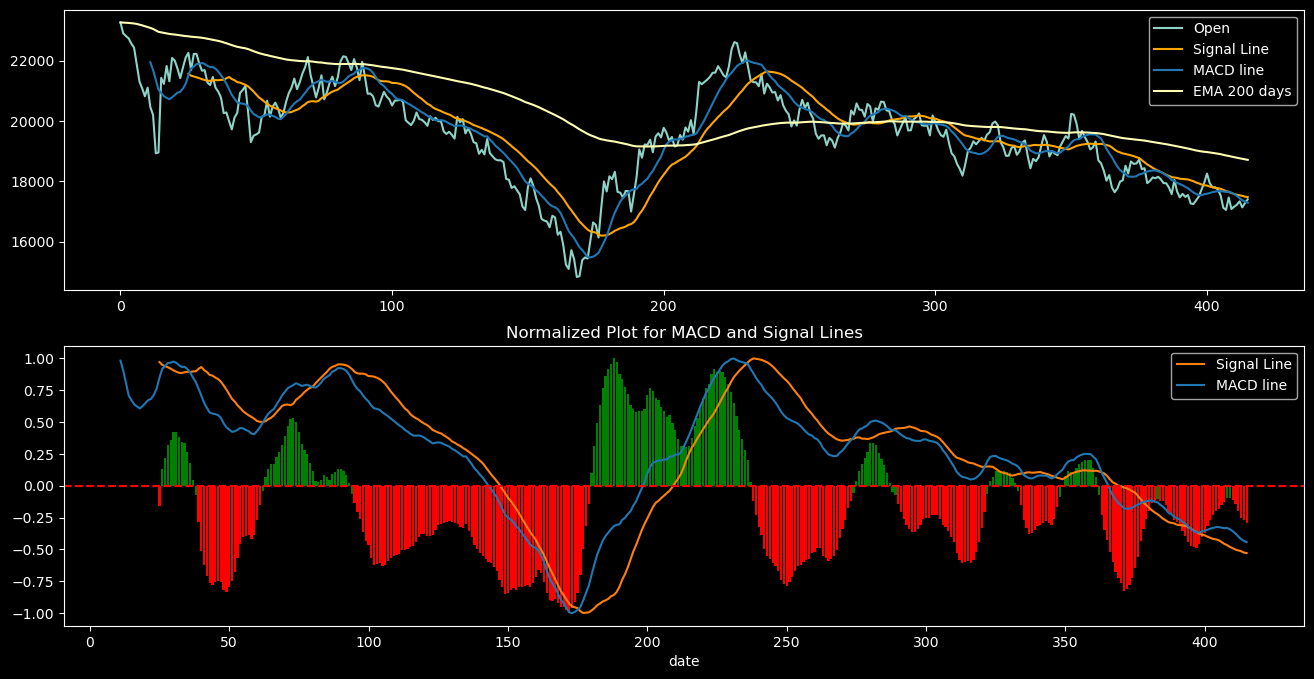

In [50]:
# 168 days EMA
ema = df['Open'].ewm(span=168, adjust=False).mean()

def normalize(df): 
    return (df - df.min() ) / (df.max() - df.min()) * 2 - 1



fig, axs = plt.subplots(2,1,figsize=(16,8))

axs[0].plot(df["Open"], label=f'Open')
axs[0].plot(signal_line, label=f'Signal Line', color='orange')
axs[0].plot(macd_line, label=f'MACD line', color='tab:blue')
axs[0].plot(ema, label=f"EMA 200 days")
axs[0].legend()




# axs[1].plot(diff_line, label='MACD - Signal')
colors = np.where(diff_line >= 0, 'green', 'red')
axs[1].set_title(f"Normalized Plot for MACD and Signal Lines")
axs[1].plot(normalize(signal_line), label=f'Signal Line', color=f"tab:orange")
axs[1].plot(normalize(macd_line), label=f'MACD line', color=f"tab:blue")
axs[1].bar(range(len(diff_line)), normalize(diff_line), color=colors)
axs[1].axhline(y=0, color='r', linestyle='--')
# plt.hist(diff_line)
axs[1].legend()
plt.xlabel('date')


# ADF Test for mean-reverting strategy

In [51]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(diff_line[~np.isnan(diff_line) ])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -3.9332166075860213
p-value: 0.0018035450077574366
Critical Values:
1%: -3.447909006729481
5%: -2.8692783343881483
10%: -2.5708923751111112


# Hurst Exponent 


In [52]:
from scipy.stats import linregress

def hurst_exponent(time_series):
    """Returns the Hurst Exponent of the time series"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]

    # Add a very small positive number to tau and lags to avoid log(0)
    tau = np.array(tau) + 1e-10
    lags = np.array(lags, dtype=float) + 1e-10
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0


log_returns = np.log(df["Open"]).diff().dropna()
# Compute the Hurst Exponent
H = hurst_exponent(log_returns)
print("Hurst Exponent:", H)

Hurst Exponent: -2.86920946788807e-16


# Half Life of mean-reverting 

In [53]:
from sklearn.linear_model import LinearRegression

lag_diff = diff_line.shift(1)

delta_y = diff_line[~ np.isnan(diff_line)]  - lag_diff[~np.isnan(lag_diff)]
clean_dy = delta_y.values[1:].reshape(-1,1)
clean_ylag = (lag_diff[~np.isnan(lag_diff)])[:].values


# Create a linear regression object
lm = LinearRegression()


# Train the model using the training sets
lm.fit(clean_dy, clean_ylag)

# Print out the coefficients
print('Intercept:', lm.intercept_)
print('Slope:', lm.coef_[0])


print(f'Half life {-np.log(2)/lm.intercept_ }')


Intercept: -62.8352399525508
Slope: -0.49553156509813784
Half life 0.011031185383924152


In [54]:
import statsmodels.api as sm

# Assuming time_series is the given discrete time series

# Prepare the data
time_series = diff_line
lagged_y = time_series.shift(1)
intercept = pd.Series(np.ones_like(time_series), index=time_series.index)
data = pd.concat([lagged_y, intercept], axis=1)
data.columns = ['lagged_y', 'intercept']
data = data.dropna()  # Remove rows with missing values

# Define the dependent and independent variables
dy = time_series.diff().dropna()
X = data[['lagged_y', 'intercept']]

# Perform OLS regression
model = sm.OLS(dy, X)
results = model.fit()

# Retrieve the estimated coefficients
lambda_hat, mu_hat = results.params['lagged_y'], results.params['intercept']

# Print the estimated parameters
print("Estimated Lambda:", lambda_hat)
print("Estimated Mu:", mu_hat)
print(f"half life { -np.log(2) / lambda_hat}")

Estimated Lambda: -0.009507061190008726
Estimated Mu: -0.9384640273742213
half life 72.90866932553203


# Backtest MACD

In [55]:
# Assuming 'df' is your pandas DataFrame with columns: 'Open', 'High', 'Low', 'Close'

# Calculate the 12-day and 26-day EMAs
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()

# Calculate the MACD Line
macd_line = ema12 - ema26

# Calculate the Signal Line
signal_line = macd_line.ewm(span=9, adjust=False).mean()

# Calculate the MACD histogram
macd_histogram = macd_line - signal_line

# Initialize variables
buy_price = 0
sell_price = 0
profit = 0
position = 0  # 0 for no position, 1 for long position

# Backtesting loop
for i in range(1, len(df)):
    if macd_line[i] > signal_line[i] and macd_line[i-1] < signal_line[i-1] and position == 0:
        # Buy signal
        buy_price = df['Close'][i]
        position = 1
    elif (macd_line[i] < signal_line[i] and macd_line[i-1] > signal_line[i-1] and position == 1) or macd_histogram[i] < 0:
        # Sell signal
        sell_price = df['Close'][i]
        profit += sell_price - buy_price
        position = 0

# Print the final profit
print("Total Profit:", profit)

Total Profit: 194893.13999999978


In [56]:
# Calculate the MACD histogram
macd_histogram = macd_line - signal_line

# Initialize variables
buy_price = 0
sell_price = 0
profit = 0
position = 0  # 0 for no position, 1 for long position

# Track daily returns for Sharpe ratio calculation
daily_returns = []

# Flag variable for the first buy signal
first_buy_signal = True

# Backtesting loop
for i in range(1, len(df)):
    if macd_line[i] > signal_line[i] and macd_line[i-1] < signal_line[i-1] and position == 0:
        # Buy signal
        if first_buy_signal:
            buy_price = df['Close'][i]  # Set initial buy price
            first_buy_signal = False
        else:
            buy_price = sell_price  # Set subsequent buy price
        position = 1
    elif (macd_line[i] < signal_line[i] and macd_line[i-1] > signal_line[i-1] and position == 1) or macd_histogram[i] < 0:
        # Sell signal
        sell_price = df['Close'][i]
        profit += sell_price - buy_price
        position = 0
        # Calculate daily return and store for Sharpe ratio calculation
        daily_return = (profit / buy_price)
        daily_returns.append(daily_return)

# Calculate Sharpe ratio
risk_free_rate = 0.02  # Assuming a risk-free rate of 2%
excess_returns = np.array(daily_returns) - risk_free_rate
excess_returns = np.isfinite(excess_returns) # exclude nan inf elements
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)  # Assuming 252 trading days in a year

# Print the Sharpe ratio
print("Sharpe Ratio:", sharpe_ratio)

Sharpe Ratio: 58.191494223812484


/var/folders/vv/80krytps22j_55gd4ylv_pvr0000gn/T/ipykernel_73723/3714837047.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  daily_return = (profit / buy_price)
